In [109]:
import numpy as np
from sys import path
path.append('../3DAssignmentSolver')

from main import Solver
from utils import create_problems, duality_visualizer


In [2]:
from scipy.optimize import linear_sum_assignment


In [437]:
N = 2
x = np.zeros((N,N,N))
x[0,0,0] = 1
x[0,1,0] = 0
x[1,0,0] = 0
x[1,1,0] = 1

x[0,0,1] = 0
x[0,1,1] = 0
x[1,0,1] = 0
x[1,1,1] = 0
np.random.seed(42)
C = np.random.randint(1, 10, size = (N, N, N))


In [417]:
solver = Solver()

In [605]:

# still need to numpy this all
def local_construct(x):
    x_copy = x.copy()
    N = np.shape(x)[0]
    ct = 0
    while ct < N:
        S = np.sum(x_copy, axis=(0, 1))
        A = np.where(S == 0)[0]
        B = np.where(S > 1)[0]
        E = np.where(S == 1)[0]
#         print(f" < 1: {A}, > 1: {B}, = 1 {E}")
        if len(A) == 0:
            break 
        else:
            D = np.full((N, N), -np.inf)
            argmax_diff = np.full((N, N, 2), -np.inf)  # 3D array to store indices (i, j, k, l)
            for i in range(N):
                for j in range(N):
                    A = np.where((x_copy[i, j, :] == 0) & (S == 0))[0] # Get the indices where both x and S are 0
                    B = np.where((x_copy[i, j, :] > 0) & (S > 1))[0]   # Get the indices where x > 0 and S > 1
                    if len(A) > 0 and len(B) > 0:
                        max_diff = -np.inf
                        for k in A:
                            for l in B:
                                diff = C[i, j, k] - C[i, j, l]
                                if diff > max_diff:
                                    max_diff = diff
                                    argmax_diff[i, j] = [k, l]  # Store the indices of the maximizing values
                        D[i, j] = max_diff

            i, j = np.unravel_index(np.argmax(D), (N,N))
            k, l = argmax_diff[i,j]
            x_copy[i, j, int(k)] = 1
            x_copy[i, j, int(l)] = 0

#             print(f"swap {i,j,k} <- 1, {i, j, l} <- 0")
#             print(f"change by {C[i,j,int(k)] - C[i,j,int(l)]}" )
            
#             print("-"*50)
            
            ct += 1
    return x_copy


In [614]:
N = 40
u = np.random.uniform(0, 10, N)


# C = np.zeros((2,2,2))
# C[0,0,0]=10
# C[0,0,1]=15
# C[1,1,0]=50
# C[1,1,1]=25

np.random.seed(1)
C = create_problems(N, 1, verbosity=False)[0]

print(f"first coef: {C[0,0,0]}")
dual_bounds, primal_bounds, sol, val, _, _ = solver.optimize(C)
print(f"opt-val: {val}")

u = u.reshape(1, 1, -1)
sum_C_u = C + u

max_indices = np.argmax(sum_C_u, axis=-1)
D = sum_C_u[np.arange(N)[:, None], np.arange(N), max_indices]
K = max_indices.squeeze()

rows, cols = linear_sum_assignment(-D)

x = np.zeros((N, N, N), dtype=int)
x[rows, cols, K[rows, cols]] = 1

print(f"feasible: {solver.is_feasible(x)}")
print(f"x-val: {solver.value(x)}")


first coef: 0.03781648924200275
opt-val: 3811.6865162576023
feasible: False
x-val: 3972.27559733575


In [620]:
def generate_bounds(n, C):
    bounds = []
    for _ in range(n):
        u = np.random.uniform(0, 0, N)
        u = u.reshape(1, 1, -1)
        sum_C_u = C + u
        
        max_indices = np.argmax(sum_C_u, axis=-1)
        D = sum_C_u[np.arange(N)[:, None], np.arange(N), max_indices]
        K = max_indices.squeeze()

        rows, cols = linear_sum_assignment(-D)

        x = np.zeros((N, N, N), dtype=int)
        x[rows, cols, K[rows, cols]] = 1

        x_new = local_construct(x)
        
        if solver.is_feasible(x_new):
            bounds.append(solver.value(x_new))
        print(solver.is_feasible(x_new))
    return bounds


In [623]:


max_indices = np.argmax(C, axis=-1)
D = C[np.arange(N)[:, None], np.arange(N), max_indices]
K = max_indices.squeeze()

rows, cols = linear_sum_assignment(-D)

x = np.zeros((N, N, N), dtype=int)
x[rows, cols, K[rows, cols]] = 1

x_new = local_construct(x)
        


solver.is_feasible(x_new)

solver.value(x_new)



3837.781766973094

In [621]:
bounds = generate_bounds(1, C)
bounds

True


[3837.781766973094]

In [617]:
ls_bound = np.max(bounds)
ls_bound

3837.781766973094

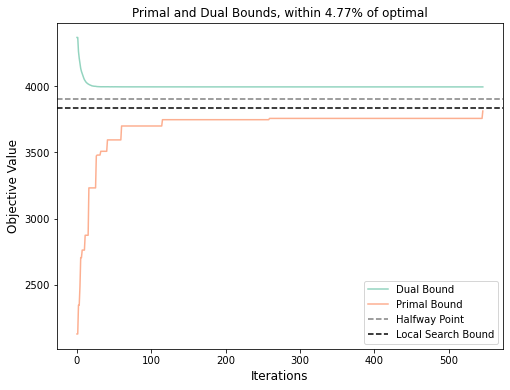

In [618]:
fraction = (dual_bounds[-1] - primal_bounds[-1]) / primal_bounds[-1]
halfway_point = (dual_bounds[-1] + primal_bounds[-1]) / 2

plt.figure(figsize=(8, 6))

colors = sns.color_palette("Set2", 2)

plt.plot(dual_bounds, label='Dual Bound', color=colors[0], alpha=0.7)
plt.plot(primal_bounds, label='Primal Bound', color=colors[1], alpha=0.7)

plt.axhline(y=halfway_point, color='gray', linestyle='--', label='Halfway Point')
plt.axhline(y=ls_bound, color='black', linestyle='--', label='Local Search Bound')

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.title(f'Primal and Dual Bounds, within {fraction * 100:.2f}% of optimal')

plt.legend()
plt.show()

In [536]:
import seaborn as sns

In [548]:
halfway_point

1457.6880785246854

In [619]:
primal_bounds[-1]

3811.6865162576023